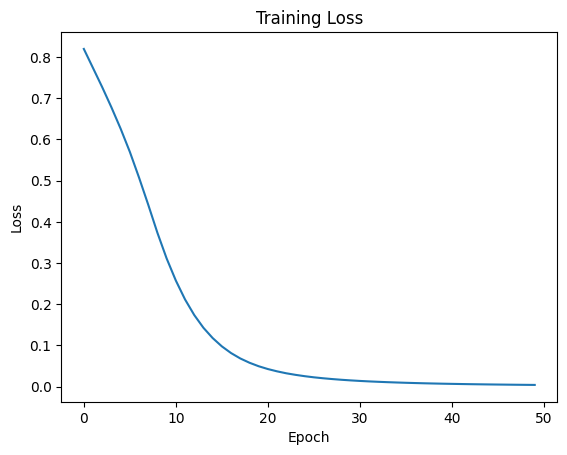

Final accuracy: 100.0%


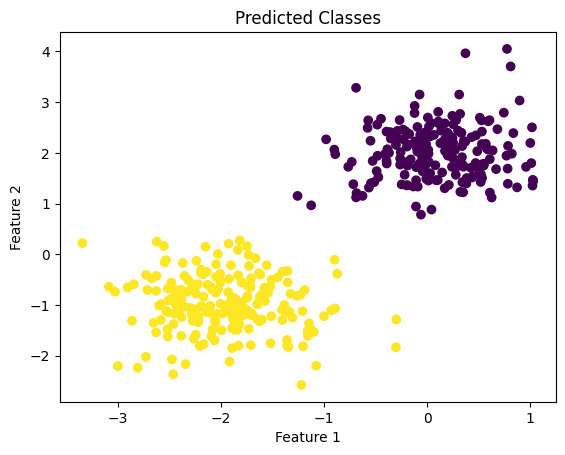

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# 1) Create a simple 2-class, 2D Gaussian dataset
torch.manual_seed(0)
N = 200
mean0 = torch.tensor([ .05,  2.0])
mean1 = torch.tensor([-2.0, -1.0])
cov   = 0.5
x0 = torch.randn(N,2) * cov + mean0
x1 = torch.randn(N,2) * cov + mean1
X  = torch.cat([x0, x1], dim=0)
Y  = torch.cat([torch.zeros(N), torch.ones(N)]).long()

ds = TensorDataset(X, Y)
loader = DataLoader(ds, batch_size=32, shuffle=True)

# 2) Define a tiny MLP
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 3) Training loop
epochs = 50
loss_history = []
for ep in range(epochs):
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    loss_history.append(running_loss / len(ds))

# 4) Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 5) Evaluate
with torch.no_grad():
    logits = model(X.to(device))
    preds  = logits.argmax(dim=1).cpu()
    acc    = (preds == Y).float().mean().item()
print(f'Final accuracy: {acc*100:.1f}%')

# 6) Scatter the data colored by predicted label
plt.figure()
plt.scatter(X[:,0], X[:,1], c=preds)
plt.title('Predicted Classes')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [10]:
xb = torch.tensor([-2.0,-1.0])
model(xb)

tensor([-4.4949,  2.5139], grad_fn=<ViewBackward0>)

In [23]:
d_to_Qn_n(-4.4949, 8)

-1151

In [11]:
import pandas as pd
import torch.nn as nn

def show_weights(model):
    """
    For each nn.Linear in `model`, prints a pandas DataFrame
    where each row is one output neuron, columns are input channels
    (plus a 'bias' column if present).
    """
    Weights = []
    Biases = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            # pull out weight and bias
            W = module.weight.detach().cpu().numpy()   # shape (out_feats, in_feats)
            b = module.bias.detach().cpu().numpy() if module.bias is not None else None

            # make column names
            in_cols = [f"in_{i}" for i in range(W.shape[1])]
            df = pd.DataFrame(W, columns=in_cols)
            if b is not None:
                df["bias"] = b
            
            Weights.append(W)
            Biases.append(b)

            print(f"\n==== Layer: {name} ({W.shape[1]} → {W.shape[0]}) ====")
            display(df)  # in a notebook this shows it nicely; in a script you could do print(df.to_string())
    return Weights, Biases

Weights, biases = show_weights(model)


==== Layer: net.0 (2 → 16) ====


,in_0,in_1,bias
0,-0.090265,-0.598816,0.482135
1,0.441489,-0.601243,-0.144902
2,-0.255189,0.538432,-0.674271
3,0.855329,0.117722,0.808806
4,0.258818,0.486901,0.464530
5,-0.453067,-0.330007,-0.155390
6,-0.150886,-0.766634,0.110337
7,0.064037,0.218612,0.088335
8,-0.579329,0.743358,0.266529
9,0.110803,0.568888,0.501779



==== Layer: net.2 (16 → 4) ====


,in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,in_9,in_10,in_11,in_12,in_13,in_14,in_15,bias
0,0.381386,0.161427,-0.190145,0.203280,-0.417287,0.061887,0.399971,-0.426647,0.273967,-0.109736,0.205492,-0.345851,0.378033,0.544766,0.373719,-0.141553,0.214322
1,0.660688,-0.057438,-0.263073,-0.128000,-0.087001,0.111376,0.279300,-0.239165,0.016887,-0.020691,0.019443,-0.043125,0.290044,0.496857,0.157986,-0.089556,0.089039
2,-0.369495,-0.288511,0.009947,0.677089,0.519312,0.002401,-0.046432,0.012354,0.293341,0.539613,-0.049061,0.679124,-0.098333,-0.043409,-0.174971,0.488438,0.206109
3,0.187572,0.120581,-0.065896,-0.022054,-0.036993,0.484195,0.557159,0.001693,0.132703,-0.235452,-0.226937,-0.345265,0.237238,0.200420,0.379973,-0.142035,0.305392



==== Layer: net.4 (4 → 2) ====


,in_0,in_1,in_2,in_3,bias
0,-0.749960,-0.625603,0.488465,-0.244072,0.233100
1,0.555336,-0.236698,-0.729525,0.618825,-0.365632


In [20]:
def d_to_Qn_n(x, n: int):
    """
    Convert a float to Qn.n fixed-point format.
    
    Parameters:
    x (float): The float number to convert.
    
    Returns:
    int: The Qn.n representation of the input float.
    """
    minval = -2**(n-1)
    maxval = 2**(n-1)-2**(-n)
    if x < minval or x > maxval:
        print('Note: Value out of range for Qn.n format. Clamping to range.')
        # Clamp the value to the range of Qn.n
        x = max(minval, min(maxval, x))
    # Scale and round to nearest integer
    qn_n_value = int(round(x * 2**n))
    qn_n_value = max(-2**(2*n-1), min(2**(2*n-1)-1, qn_n_value))
    
    return qn_n_value

def Qn_n_to_d(x, n: int):
    """
    Convert a Qn.n fixed-point number to float.
    
    Parameters:
    x (int): The Qn.n number to convert.
    
    Returns:
    float: The float representation of the input Qn.n number.
    """
    # Convert to float and scale down
    d_value = x / 2**n
    return d_value

q = 8 # Qq.q format
for i, W in enumerate(Weights):
    print(f"\nLayer {i+1} weights in Q{q}.{q} format:")
    num_rows, num_cols = W.shape
    for n, row in enumerate(W):
        qn_n_row = [d_to_Qn_n(val, q) for val in row]
        for m, el in enumerate(qn_n_row):
            if el < 0:
                print(f"-{2*q}'d{abs(el)} ", end="")
            else:
                print(f"{2*q}'d{el} ", end="")
            if not((n == num_rows - 1) and (m == num_cols - 1)):
                print(", ", end="")
        print('')
    print(f"\nLayer {i+1} biases in Q{q}.{q} format:")
    if biases[i] is not None:
        qn_n_biases = [d_to_Qn_n(val, q) for val in biases[i]]
        len_biases = len(qn_n_biases)
        for n, el in enumerate(qn_n_biases):
            if el < 0:
                print(f"-{2*q}'d{abs(el)} ", end="")
            else:
                print(f"{2*q}'d{el} ", end="")
            if n < len_biases - 1:
                print(", ")
    else:
        print("No biases in this layer.")
    print("\n")


Layer 1 weights in Q8.8 format:
-16'd23 , -16'd153 , 
16'd113 , -16'd154 , 
-16'd65 , 16'd138 , 
16'd219 , 16'd30 , 
16'd66 , 16'd125 , 
-16'd116 , -16'd84 , 
-16'd39 , -16'd196 , 
16'd16 , 16'd56 , 
-16'd148 , 16'd190 , 
16'd28 , 16'd146 , 
16'd152 , -16'd77 , 
16'd102 , 16'd44 , 
-16'd97 , -16'd101 , 
-16'd79 , -16'd134 , 
-16'd28 , -16'd62 , 
16'd134 , 16'd59 

Layer 1 biases in Q8.8 format:
16'd123 , 
-16'd37 , 
-16'd173 , 
16'd207 , 
16'd119 , 
-16'd40 , 
16'd28 , 
16'd23 , 
16'd68 , 
16'd128 , 
16'd6 , 
16'd157 , 
16'd145 , 
16'd36 , 
16'd139 , 
16'd234 


Layer 2 weights in Q8.8 format:
16'd98 , 16'd41 , -16'd49 , 16'd52 , -16'd107 , 16'd16 , 16'd102 , -16'd109 , 16'd70 , -16'd28 , 16'd53 , -16'd89 , 16'd97 , 16'd139 , 16'd96 , -16'd36 , 
16'd169 , -16'd15 , -16'd67 , -16'd33 , -16'd22 , 16'd29 , 16'd72 , -16'd61 , 16'd4 , -16'd5 , 16'd5 , -16'd11 , 16'd74 , 16'd127 , 16'd40 , -16'd23 , 
-16'd95 , -16'd74 , 16'd3 , 16'd173 , 16'd133 , 16'd1 , -16'd12 , 16'd3 , 16'd75 , 16'd138 

In [21]:
in1 = d_to_Qn_n(-2.0, 8)
in2 = d_to_Qn_n(-1.0, 8)

print(f"Input in Q8.8 format: {in1}, {in2}")

Input in Q8.8 format: -512, -256
